In [13]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import legacy
from sklearn.metrics import classification_report, confusion_matrix

In [14]:
dataset_dir = 'data/tomatect'
base_dir = 'data/splits'
train_pct = 0.8
validation_pct = 0.15
test_pct = 0.05
img_width = 256
img_height = 256
batch_size = 32

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [24]:
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=123,
    shuffle=True,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

dataset_validation = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    seed=123,
    shuffle=True,
    image_size=(img_height,img_width),
    batch_size=batch_size
)


dataset_test = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=123,
    shuffle=False,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 8000 files belonging to 10 classes.
Found 1500 files belonging to 10 classes.
Found 500 files belonging to 10 classes.


In [25]:
class_names = dataset_train.class_names

dataset_train = dataset_train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
dataset_validation = dataset_validation.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
dataset_test = dataset_test.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
data_scaling = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(img_height, img_width),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
   tf.keras.layers.experimental.preprocessing.RandomRotation(0.9),
   tf.keras.layers.experimental.preprocessing.RandomContrast(0.5),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2)    
])

In [27]:
train_ds = dataset_train.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [28]:
input_shape = (batch_size, img_width, img_height, 3)
n_classes = 10

In [29]:
model = tf.keras.models.Sequential([
    data_scaling,
  #  data_augmentation,
    tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax'),
])

In [30]:
model.build(input_shape=input_shape)

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (32, 60, 60, 64)         

In [31]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [34]:
history = model.fit(
    dataset_train,
    batch_size=32,
    #steps_per_epoch=len(dataset_test)// batch_size,
    validation_data=dataset_validation,
    verbose=1,
    epochs=25,
)

Epoch 1/25
250/250 [==============================] - 123s 491ms/step - loss: 0.2323 - accuracy: 0.9168 - val_loss: 0.2931 - val_accuracy: 0.8993
Epoch 2/25
250/250 [==============================] - 124s 494ms/step - loss: 0.1740 - accuracy: 0.9378 - val_loss: 0.2588 - val_accuracy: 0.9180
Epoch 3/25
250/250 [==============================] - 116s 461ms/step - loss: 0.1270 - accuracy: 0.9559 - val_loss: 0.2637 - val_accuracy: 0.9113
Epoch 4/25
250/250 [==============================] - 113s 452ms/step - loss: 0.1268 - accuracy: 0.9540 - val_loss: 0.2454 - val_accuracy: 0.9160
Epoch 5/25
250/250 [==============================] - 118s 471ms/step - loss: 0.0954 - accuracy: 0.9673 - val_loss: 0.1882 - val_accuracy: 0.9407
Epoch 6/25
250/250 [==============================] - 116s 464ms/step - loss: 0.0571 - accuracy: 0.9806 - val_loss: 0.2985 - val_accuracy: 0.9233
Epoch 7/25
250/250 [==============================] - 109s 436ms/step - loss: 0.1084 - accuracy: 0.9626 - val_loss: 0.2199 -

In [35]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/gv/329dcxbs405bx2j0y5mdlxvm0000gn/T/tmpgmm06msc/assets


INFO:tensorflow:Assets written to: /var/folders/gv/329dcxbs405bx2j0y5mdlxvm0000gn/T/tmpgmm06msc/assets
2023-06-14 12:43:36.809674: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-06-14 12:43:36.809850: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-06-14 12:43:36.812798: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/gv/329dcxbs405bx2j0y5mdlxvm0000gn/T/tmpgmm06msc
2023-06-14 12:43:36.817363: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-06-14 12:43:36.817376: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/gv/329dcxbs405bx2j0y5mdlxvm0000gn/T/tmpgmm06msc
2023-06-14 12:43:36.826219: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2023-06-14 12:43:36.829284: I tensorflow/cc/saved_model/load

In [36]:
# Save the TFLite model to a file
with open('model_data_public.tflite', 'wb') as f:
    f.write(tflite_model)

In [37]:
model.save('model_public.h5')

/Users/aldalatifah/dev/my_test_project/myvenv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [39]:
scores = model.evaluate(dataset_test)
print(f'Test Loss: {scores[0]:.3f}')
print(f'Test Accuracy: {scores[1]:.3f}')

16/16 [==============================] - 2s 110ms/step - loss: 0.1340 - accuracy: 0.9600
Test Loss: 0.134
Test Accuracy: 0.960


In [41]:
label_test = dataset_test.map(lambda image, label:label)

In [42]:
label_test = np.concatenate([label.numpy() for _, label in dataset_test])

In [45]:
y_pred = model.predict(dataset_test)
y_pred = np.argmax(y_pred, axis=1)

16/16 [==============================] - 2s 123ms/step


In [46]:
con_mat = confusion_matrix(label_test, y_pred)
print(con_mat)

[[47  0  0  0  0  0  0  0  0  3]
 [ 0 47  0  2  0  0  0  0  0  1]
 [ 0  0 50  0  0  0  0  0  0  0]
 [ 3  3  0 44  0  0  0  0  0  0]
 [ 0  0  0  1 47  0  1  0  0  1]
 [ 0  0  0  0  0 50  0  0  0  0]
 [ 0  0  0  0  0  0 49  0  1  0]
 [ 0  0  0  0  0  0  0 50  0  0]
 [ 0  1  1  0  0  0  1  1 46  0]
 [ 0  0  0  0  0  0  0  0  0 50]]


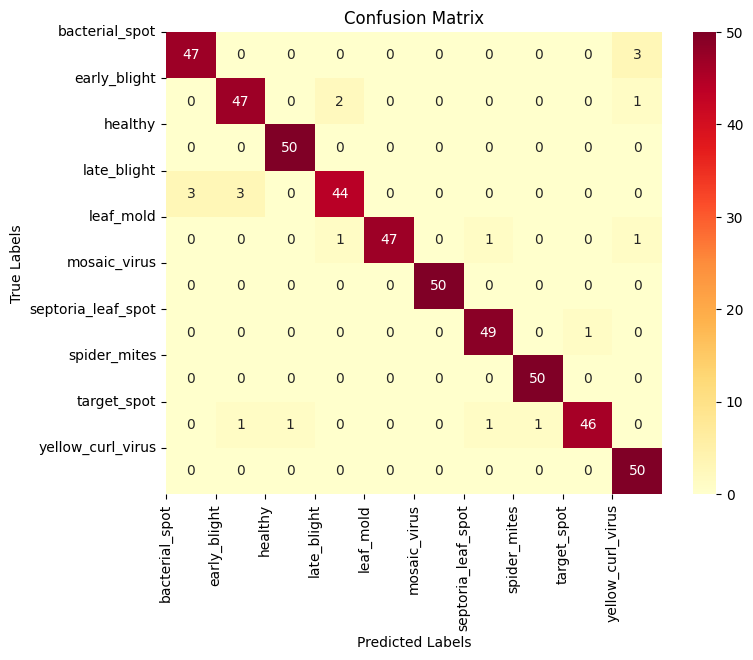

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(8, 6))
sns.heatmap(con_mat, annot=True, cmap='YlOrRd', xticklabels=class_names, yticklabels=class_names)

# Add labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=range(len(class_names)), labels=class_names)
plt.yticks(ticks=range(len(class_names)), labels=class_names)

plt.show()

In [52]:
# Define true positive, true negative, false positive, false negative
TP = np.diag(con_mat)
TN = np.sum(con_mat) - (np.sum(con_mat, axis=0) + np.sum(con_mat, axis=1) - TP)
FP = np.sum(con_mat, axis=0) - TP
FN = np.sum(con_mat, axis=1) - TP

In [57]:
print("TP : ", TP)
print("TN : ", TN)
print("FP : ", FP)
print("FN : ", FN)

TP :  [47 47 50 44 47 50 49 50 46 50]
TN :  [447 446 449 447 450 450 448 449 449 445]
FP :  [3 4 1 3 0 0 2 1 1 5]
FN :  [3 3 0 6 3 0 1 0 4 0]


In [53]:
# Calculate accuracy, recall, and precision for each class
accuracy = TP / (TP + FP + FN)
recall = TP / (TP + FN)
precision = TP / (TP + FP)

In [54]:
for i in range(len(class_names)):
    print(f'Class: {class_names[i]}')
    print(f'Accuracy: {accuracy[i]:.4f}')
    print(f'Recall: {recall[i]:.4f}')
    print(f'Precision: {precision[i]:.4f}')
    print('---')

Class: bacterial_spot
Accuracy: 0.8868
Recall: 0.9400
Precision: 0.9400
---
Class: early_blight
Accuracy: 0.8704
Recall: 0.9400
Precision: 0.9216
---
Class: healthy
Accuracy: 0.9804
Recall: 1.0000
Precision: 0.9804
---
Class: late_blight
Accuracy: 0.8302
Recall: 0.8800
Precision: 0.9362
---
Class: leaf_mold
Accuracy: 0.9400
Recall: 0.9400
Precision: 1.0000
---
Class: mosaic_virus
Accuracy: 1.0000
Recall: 1.0000
Precision: 1.0000
---
Class: septoria_leaf_spot
Accuracy: 0.9423
Recall: 0.9800
Precision: 0.9608
---
Class: spider_mites
Accuracy: 0.9804
Recall: 1.0000
Precision: 0.9804
---
Class: target_spot
Accuracy: 0.9020
Recall: 0.9200
Precision: 0.9787
---
Class: yellow_curl_virus
Accuracy: 0.9091
Recall: 1.0000
Precision: 0.9091
---


In [64]:
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 

for image_name in os.listdir("data/tomatect/early_blight") : 
    img_n = os.path.join("data/tomatect/early_blight", image_name)
    if(img_n.endswith('.jpg') or img_n.endswith('.png') or img_n.endswith('.jpeg')) :
        img = image.load_img(img_n, target_size=(256,256))
        print("name : ", img_n)
        # imgplot = plt.imshow(img)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        
        images = np.vstack([x])
        classes = model.predict(images, batch_size=32)
        print("Hasil : ", class_names[np.argmax(classes)])

In [65]:
img = image.load_img("data/tomatect/early_blight/3fa32b26-e7bb-493e-b7c2-c40e3f3df380___RS_Erly.B 9546.JPG", target_size=(256,256))
print("name : ", "data/tomatect/early_blight/3fa32b26-e7bb-493e-b7c2-c40e3f3df380___RS_Erly.B 9546.JPG")
# imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=32)
print("Hasil : ", class_names[np.argmax(classes)])

name :  data/tomatect/early_blight/3fa32b26-e7bb-493e-b7c2-c40e3f3df380___RS_Erly.B 9546.JPG
1/1 [==============================] - 0s 81ms/step
Hasil :  early_blight


In [ ]:
import cv2